In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from PIL import Image, ImageOps
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.ndimage



In [5]:
def load_images_from_folder(folder, image_size=(128, 128),rot=False,flip=False):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpeg") or filename.endswith(".jpg"):
            with Image.open(os.path.join(folder, filename)) as img:
                img = img.resize(image_size)  # Resize image to a fixed size
                img = img.convert('L')  # Convert image to grayscale (optional)
                if rot:
                    img_rot = img.rotate(20)  # Rotate the image by 20 degrees
                    img_rot = np.array(img_rot)  # Convert to array
                    img_rot = img_rot[..., np.newaxis]  # Add channel dimension
                    img_rot = img_rot / 255.0  # Normalize to [0, 1]
                    images.append(img_rot.flatten())  # Flatten the image to a 1D array
                if flip:
                    img_flip = ImageOps.mirror(img)
                    img_flip = np.array(img_flip)  # Convert to array
                    img_flip = img_flip[..., np.newaxis]  # Add channel dimension
                    img_flip = img_flip / 255.0  # Normalize to [0, 1]
                    images.append(img_flip.flatten())  # Flatten the image to a 1D array
                img = np.array(img)  # Convert to array
                img = img[..., np.newaxis]  # Add channel dimension
                img = img / 255.0  # Normalize to [0, 1]
                images.append(img.flatten())  # Flatten the image to a 1D array
    return np.array(images)

def mix_up(dog, cat):
    if dog.shape[0] < cat.shape[0]:
        rows = dog.shape[0]
        columns = dog.shape[1]
    else:
        rows = cat.shape[0]
        columns = cat.shape[1]
    
    X_outcome = np.zeros(rows*2*columns).reshape(rows*2, columns)
    Y_outcome = np.zeros(rows*2).reshape(rows*2, 1)
    cat_place = 0
    dog_place = 0
    
    for j in range(rows*2):
        if (j % 2) == 0:
            X_outcome[j,:] = dog[dog_place, :]
            dog_place += 1
            Y_outcome[j] = 1
        else:
            X_outcome[j,:] = cat[cat_place,:]
            cat_place += 1
            Y_outcome[j] = 0
    return X_outcome, Y_outcome

def split_data(X, Y, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):

    # Calculate the number of samples for each set
    total_samples = X.shape[0]
    train_size = int(total_samples * train_ratio)
    val_size = int(total_samples * val_ratio)
    test_size = total_samples - (train_size + val_size)
    
    # Split the data
    X_train = X[:train_size]
    Y_train = Y[:train_size]
    X_val = X[train_size:train_size + val_size]
    Y_val = Y[train_size:train_size + val_size]
    X_test = X[train_size + val_size:]
    Y_test = Y[train_size + val_size:]
    
    return (X_train, Y_train), (X_val, Y_val), (X_test, Y_test)

def plot_history(history, model_number):
    train_loss = [1 - x for x in history.history['loss']]
    val_loss = [1 - x for x in history.history['val_loss']]
    train_accuracy = [1 - x for x in history.history['accuracy']]
    val_accuracy = [1 - x for x in history.history['val_accuracy']]

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))


    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b', label='Training error')
    plt.plot(epochs, val_accuracy, 'r', label='Validation error')
    plt.title(f'Model {model_number} - Training and Validation error')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to be monitored
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch
)

def shuffle_in(X,Y,X1,Y1):
    j = 0
    rows = X.shape[0]
    columns = X.shape[1]
    end_X = np.zeros(rows*2*columns).reshape(rows*2,columns)
    end_Y = np.zeros(rows*2).reshape(rows*2,1)
    for i in range(0, rows*2, 2):
        end_X[i,:], end_X[i+1,:] = X[j,:], X1[j,:]
        end_Y[i,:], end_Y[i+1,:] = Y[j,:], Y1[j,:]
        j += 1
    
    return end_X, end_Y

In [6]:
cat_folder_path = '/Users/tomerweissman/Coding Shit/PetImages/Cat'
dog_folder_path = '/Users/tomerweissman/Coding Shit/PetImages/Dog'


cat_image_matrix = load_images_from_folder(cat_folder_path, rot=True, flip=True)
dog_image_matrix = load_images_from_folder(dog_folder_path, rot=True, flip=True)


X_catdog, Y_catdog = mix_up(dog_image_matrix, cat_image_matrix)


(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_data(X_catdog, Y_catdog)


/Applications/anaconda3/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [7]:
model1 = Sequential(
    [
        tf.keras.Input(shape=(16384,)),
        Dense(15, activation='relu',kernel_regularizer=l2(0.00001)),
        Dense(10, activation='relu',kernel_regularizer=l2(0.00001)),
        Dense(1, activation='sigmoid',kernel_regularizer=l2(0.00001))
    ])


model1.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=['accuracy']
)

history1 = model1.fit(
    X_train,Y_train,
    epochs=80,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping] 
)


Epoch 1/80
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.5218 - loss: 0.6938 - val_accuracy: 0.5603 - val_loss: 0.6879
Epoch 2/80
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5747 - loss: 0.6844 - val_accuracy: 0.5957 - val_loss: 0.6771
Epoch 3/80
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5913 - loss: 0.6750 - val_accuracy: 0.5987 - val_loss: 0.6704
Epoch 4/80
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6006 - loss: 0.6683 - val_accuracy: 0.6037 - val_loss: 0.6668
Epoch 5/80
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6068 - loss: 0.6629 - val_accuracy: 0.6034 - val_loss: 0.6643
Epoch 6/80
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6050 - loss: 0.6606 - val_accuracy: 0.6016 - val_loss: 0.6638
Epoch 7/80
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6073 - loss: 0.6603 - val_accuracy: 0.6061 - val_loss: 0.6623
Epoch 8/80
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6089 - loss: 0.6573 -

In [8]:
j_cv1 = 1- history1.history['val_accuracy'][-1]
j_train1 = 1- history1.history['accuracy'][-1]

print(f"model1; cv: {j_cv1}; train: {j_train1}")


model1; cv: 0.37852251529693604; train: 0.36028194427490234


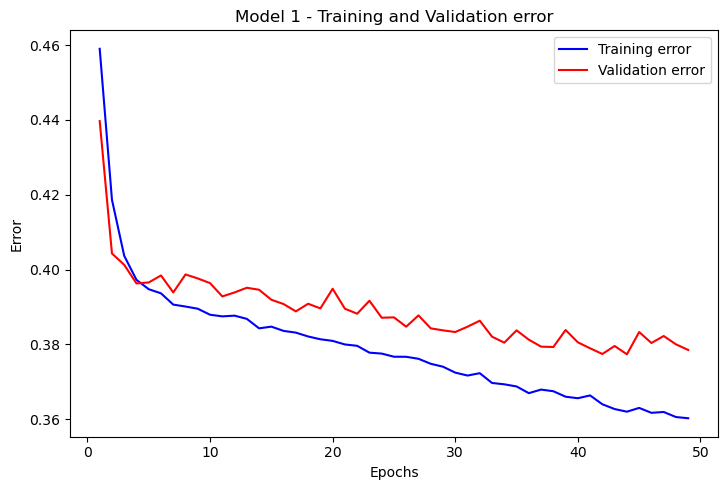

In [9]:


plot_history(history1, 1)


In [10]:
history1 = model1.fit(
    X_train,Y_train,
    epochs=80,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping] 
)


Epoch 1/80
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6376 - loss: 0.6340 - val_accuracy: 0.6221 - val_loss: 0.6455
Epoch 2/80
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6373 - loss: 0.6331 - val_accuracy: 0.6193 - val_loss: 0.6460
Epoch 3/80
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6389 - loss: 0.6323 - val_accuracy: 0.6198 - val_loss: 0.6469
Epoch 4/80
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6363 - loss: 0.6320 - val_accuracy: 0.6217 - val_loss: 0.6458
Epoch 5/80
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6396 - loss: 0.6305 - val_accuracy: 0.6209 - val_loss: 0.6455
Epoch 6/80
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6403 - loss: 0.6323 - val_accuracy: 0.6256 - val_loss: 0.6453
Epoch 7/80
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6409 - loss: 0.6277 - val_accuracy: 0.6205 - val_loss: 0.6452
Epoch 8/80
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6411 - loss: 0.6297 -

In [11]:
tester = 0
testerer = X_test.shape[0]
for i in range(X_test.shape[0]):
    if model1.predict(X_test[i,:].reshape(1,-1)) < 0.5:
        if Y_test[i] == 1:
            tester += 1
    if model1.predict(X_test[i,:].reshape(1,-1)) >= 0.5:
        if Y_test[i] == 0:
            tester += 1
print(tester/testerer)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [12]:
print(tester/testerer)



0.38755555555555554


/Applications/anaconda3/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


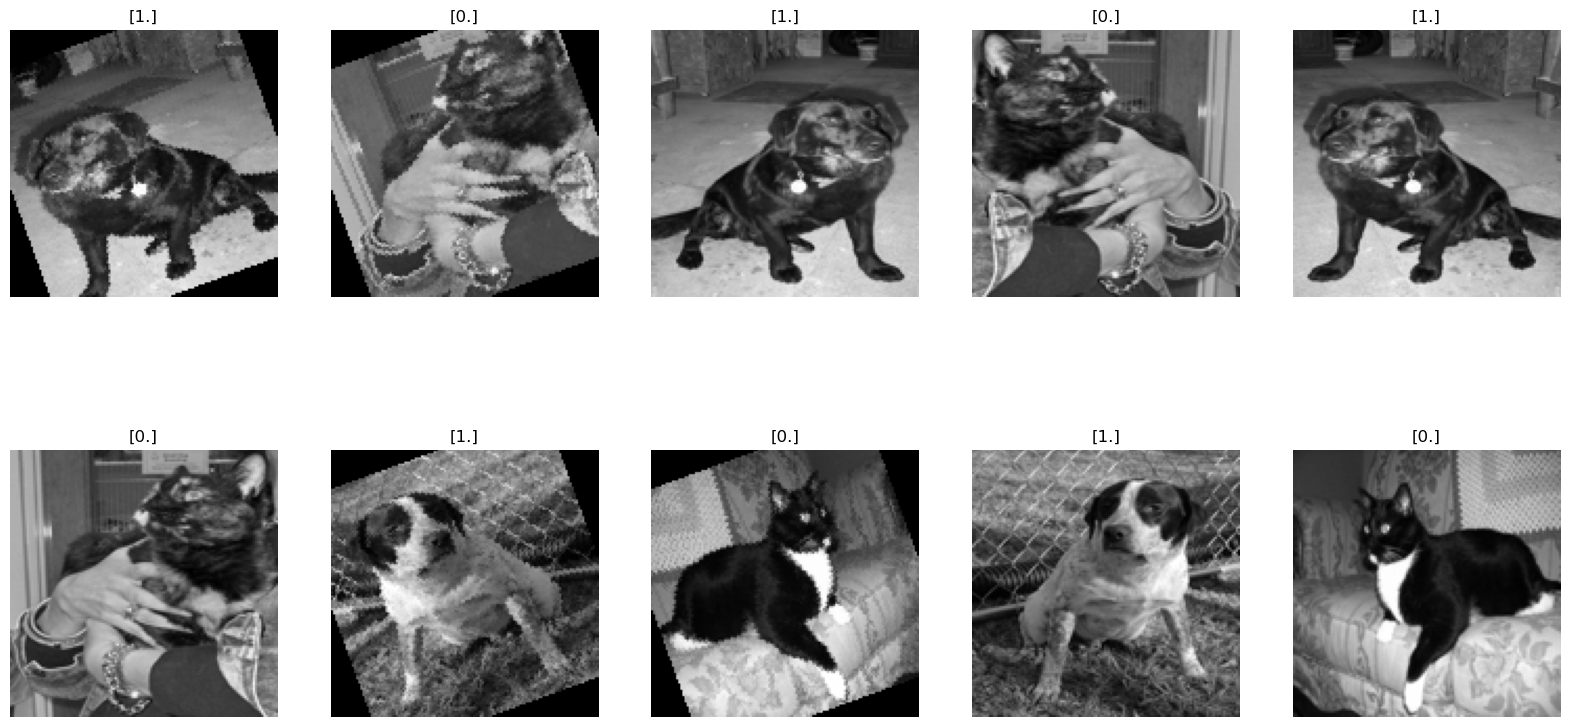

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Assuming `X_outcome` is your image data and `Y_outcome` is your labels
# If your images are flattened, you might need to reshape them to their original dimensions

def display_images(images, labels, image_size=(128, 128), num_images=10):
    plt.figure(figsize=(20, 10))
    
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        img = images[i].reshape(image_size)  # Reshape if the images are flattened
        plt.imshow(img, cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    
    plt.show()

# Load a sample of images for visualization
# Replace 'X_outcome' and 'Y_outcome' with your actual variables
sample_images = X_catdog[:10]
sample_labels = Y_catdog[:10]

# Display the images
display_images(sample_images, sample_labels, image_size=(128, 128), num_images=10)
